In [1]:
import os
import os.path
import pickle

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix

In [2]:
NOTE = '全特徴量を使用したSVM. class_weight を指定。Cは100'

N = 5
CV = f'Stratified-Kfold(K={N})'

notebook_name = '012_SVM_balanced_C100'
OUTPUT_DIR = os.path.basename(notebook_name)
SUB_FILENAME = notebook_name[:3] + '_submission.csv'
assert(SUB_FILENAME not in pd.read_csv('submissions.csv').filename.tolist())
print(SUB_FILENAME, OUTPUT_DIR)
if not os.path.isdir(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

SEED = 1
CATEGORICAL_FEATURES =  [
        'batterID', 'pitcherID', 'Match',
        'isBatterHandLeft', 'isPitcherHandLeft', 'isBatterPitcher',
        'isBottom', 'batterTeam', 'pitcherTeam'
    ]

012_submission.csv 012_SVM_balanced_C100


In [3]:
def get_estimator(categorical_features, discrete_features):
    discrete_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    preprocessor = ColumnTransformer(
        transformers=[
            ('discrete', discrete_transformer, discrete_features),
            ('categorical', 'passthrough', categorical_features),
        ]
    )
    return Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('estimator', SVC(C=100.0, random_state=SEED, class_weight='balanced'))
        ]
    )

In [4]:
train = pd.read_csv(os.path.join('001_EDA', 'train_data_preprocessed.csv'))
test = pd.read_csv(os.path.join('001_EDA', 'test_data_preprocessed.csv'))

In [5]:
for c in CATEGORICAL_FEATURES:
    assert(train[c].isin(test[c]).sum() == train.shape[0])
    assert(test[c].isin(train[c]).sum() == test.shape[0])

train = pd.get_dummies(train, columns=CATEGORICAL_FEATURES, drop_first=True)
test = pd.get_dummies(test, columns=CATEGORICAL_FEATURES, drop_first=True)

assert(set(train.columns.tolist()) - set(test.columns.tolist()) == {'y'})
assert(set(test.columns.tolist()) - set(train.columns.tolist()) == set())

In [6]:
categorical_features = []
for c in CATEGORICAL_FEATURES:
    categorical_features += [c_ for c_ in train.columns if c_.startswith(f'{c}_')]
categorical_features

['batterID_0',
 'batterID_2',
 'batterID_5',
 'batterID_9',
 'batterID_11',
 'batterID_12',
 'batterID_15',
 'batterID_18',
 'batterID_19',
 'batterID_21',
 'batterID_22',
 'batterID_26',
 'batterID_27',
 'batterID_28',
 'batterID_29',
 'batterID_31',
 'batterID_34',
 'batterID_36',
 'batterID_37',
 'batterID_39',
 'batterID_42',
 'batterID_45',
 'batterID_47',
 'batterID_50',
 'batterID_55',
 'batterID_56',
 'batterID_58',
 'batterID_60',
 'batterID_67',
 'batterID_70',
 'batterID_72',
 'batterID_73',
 'batterID_75',
 'batterID_80',
 'batterID_82',
 'batterID_84',
 'batterID_85',
 'batterID_87',
 'batterID_89',
 'batterID_91',
 'batterID_98',
 'batterID_102',
 'batterID_103',
 'batterID_105',
 'batterID_106',
 'batterID_111',
 'batterID_112',
 'batterID_114',
 'batterID_117',
 'batterID_118',
 'batterID_120',
 'batterID_121',
 'batterID_125',
 'batterID_127',
 'batterID_128',
 'batterID_130',
 'batterID_132',
 'batterID_134',
 'batterID_135',
 'batterID_137',
 'batterID_138',
 'batter

In [7]:
features = [c for c in train.columns if c not in ('id', 'y')]
assert(set(features) - set(test.columns.tolist()) == set())

In [8]:
discrete_features = [f for f in features if f not in categorical_features]
discrete_features

['totalPitchingCount',
 'B',
 'S',
 'O',
 'b1',
 'b2',
 'b3',
 'inningNo',
 'numRunners',
 'pitcherHoursElapsed',
 'pitcherNumGamesParticipated',
 'batterHoursElapsed',
 'batterNumGamesParticipated',
 'ballPositionLabel__no_data__',
 'ど真ん中',
 '内角中心',
 '内角低め',
 '内角高め',
 '外角中心',
 '外角低め',
 '外角高め',
 '真ん中低め',
 '真ん中高め',
 'ballPositionLabeld1',
 'ballPositionLabeld2',
 'ballPositionLabeld3',
 'ballPositionLabeld4',
 'ballPositionLabeld5',
 'ballPositionLabeld6',
 'ballPositionLabeld7',
 'ballPositionLabeld8',
 'ballPositionLabeld9',
 'ballPositionLabeld10',
 'ballPositionLabeld11',
 'ballPositionLabeld12',
 'ballPositionLabeld13',
 'ballPositionLabeld14',
 'ballPositionLabeld15',
 'ballPositionLabeld16',
 'ballPositionLabeld17',
 'ballPositionLabeld18',
 'ballPositionLabeld19',
 'ballPositionLabeld20',
 'ballPositionLabeld21',
 'ballPositionLabeld22',
 'ballPositionLabeld23',
 'ballPositionLabeld24',
 'ballPositionLabeld25',
 'ballPositionLabeld26',
 'ballPositionLabeld27',
 'ballPositionLabe

In [9]:
%%time
splitter = StratifiedKFold(shuffle=True, random_state=SEED, n_splits=N)
cv_pred_dfs = []
pred_dfs = []
metrics = {'train': [], 'valid': []}
models = []
for i, (train_idx, valid_idx) in enumerate(splitter.split(train, train.y)):
    id_train, X_train, y_train, id_valid, X_valid, y_valid = (
        train.iloc[train_idx].id,
        train.iloc[train_idx][features],
        train.iloc[train_idx].y,
        train.iloc[valid_idx].id,
        train.iloc[valid_idx][features],
        train.iloc[valid_idx].y,
    )
    clf = get_estimator(categorical_features, discrete_features)
    clf.fit(X_train, y_train)
    models.append(clf)
    # Evaluate (trian set)
    pred_train = clf.predict(X_train)
    pred_train_df = pd.DataFrame(
        {
            'id': id_train,
            'actual': y_train,
            'prediction': pred_train,
        }
    )
    pred_train_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for train set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_train, pred_train))
    print()
    metrics['train'].append(f1_score(y_train, pred_train, average='macro'))
    # Evaluate (valid set)
    pred_valid = clf.predict(X_valid)
    pred_valid_df = pd.DataFrame(
        {
            'id': id_valid,
            'actual': y_valid,
            'prediction': pred_valid,
        }
    )
    pred_valid_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for validation set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_valid, pred_valid))
    print()
    metrics['valid'].append(f1_score(y_valid, pred_valid, average='macro'))
    # Save cv result
    cv_pred_df = pd.concat([pred_train_df, pred_valid_df], axis=0)
    cv_pred_df['fold'] = i + 1
    cv_pred_dfs.append(cv_pred_df)
    # Inference
    try:
        infer = clf.predict_proba(test[features].copy())
    except AttributeError:
        infer = clf.decision_function(test[features].copy())
    pred_df = pd.DataFrame(
        data=infer,
        columns=clf[-1].classes_
    )
    pred_df['id'] = test.id.values
    pred_df['fold'] = i + 1
    pred_dfs.append(pred_df)



**********Confusion matrix for train set (Fold 1)**********
[[4455  327  268    8    1    2    4    1]
 [ 161 3464  115    1    1    0    3    1]
 [  44   56 2245    3   33    7    0    5]
 [   0    0    0 1709    0    0    0    0]
 [   0    0    0    0  540    0    0    0]
 [   0    0    0    0    0  150    0    0]
 [   0    0    0    0    0    0    8    0]
 [   0    0    0    0    0    0    0   96]]

**********Confusion matrix for validation set (Fold 1)**********
[[810 237 132  74   9   0   1   4]
 [281 427 130  88   5   2   0   3]
 [190 188 145  58  12   3   0   3]
 [107  82  43 187   7   1   0   0]
 [ 31  31  18  48   7   0   0   0]
 [ 10   7   4  13   3   0   0   0]
 [  2   0   1   0   0   0   0   0]
 [  5   6   3  10   0   0   0   0]]

**********Confusion matrix for train set (Fold 2)**********
[[4390  361  304    7    0    1    2    1]
 [ 168 3424  151    0    0    0    3    0]
 [  49   86 2209    2   34    8    1    4]
 [   0    0    0 1709    0    0    0    0]
 [   0    0    

In [10]:
metrics = pd.DataFrame(metrics).describe()
metrics.to_csv(os.path.join(OUTPUT_DIR, 'metrics.csv'))
metrics

,train,valid
count,5.000000,5.000000
mean,0.913259,0.228066
std,0.004385,0.004394
min,0.906887,0.223410
25%,0.910821,0.225900
50%,0.914903,0.226424
75%,0.915847,0.229812
max,0.917839,0.234784


In [11]:
cv_results = pd.concat(cv_pred_dfs)
cv_results.to_csv(os.path.join(OUTPUT_DIR, 'cross_validation.csv'), index=False)
cv_results

,id,actual,prediction,train,fold
0,0,0,0,0,1
1,1,1,1,0,1
2,2,0,0,0,1
3,3,2,2,0,1
4,4,4,4,0,1
...,...,...,...,...,...
17126,9690,0,2,0,5
17129,9693,1,1,0,5
17130,16833,1,1,0,5
17133,9762,1,2,0,5


In [12]:
submission_ = pd.concat(pred_dfs)
submission_

,0,1,2,3,4,5,6,7,id,fold
0,0.682724,5.296224,6.295199,7.297933,4.262569,1.836153,-0.291884,2.974642,27446,1
1,4.249584,5.281162,7.307255,6.272670,2.744598,0.708322,-0.296654,1.712460,113,1
2,5.318300,7.319553,6.320285,3.695425,2.684881,0.684725,-0.301562,1.688789,4479,1
3,6.318116,6.318734,6.320131,3.698044,2.685591,0.684751,-0.301699,1.689222,29080,1
4,7.319254,5.246379,6.309640,3.773868,2.706889,1.699971,-0.299980,0.694038,19319,1
...,...,...,...,...,...,...,...,...,...,...
33803,2.702725,7.318769,5.298903,6.307367,3.859465,1.715798,-0.303638,0.684761,24272,5
33804,1.680422,1.680421,1.680838,7.324976,6.318584,5.307019,-0.289815,4.259219,29106,5
33805,1.679380,1.680170,1.676959,7.325893,6.319693,5.310861,-0.288341,4.283067,20679,5
33806,6.321005,0.678316,2.681905,7.320340,5.300902,4.220315,-0.297177,1.720325,25901,5


In [13]:
submission_ = submission_.groupby('id')[[0, 1, 2, 3, 4, 5, 6, 7]].sum().sort_index().reset_index()
submission_

,id,0,1,2,3,4,5,6,7
0,0,26.430322,36.606395,31.598210,18.573665,13.460827,8.477015,-1.521252,3.426806
1,1,29.579960,35.587891,29.587107,18.550196,12.433918,9.458685,-1.521500,3.450794
2,2,3.385139,8.524012,13.456259,36.602102,31.579499,22.479887,-1.425288,25.442885
3,3,27.480109,31.497791,21.365670,35.440667,14.881423,8.541428,-1.512623,3.475863
4,4,31.595566,36.602509,26.555221,18.520915,13.444305,8.444770,-1.511056,3.433450
...,...,...,...,...,...,...,...,...,...
33803,33803,36.611412,20.560466,31.501336,19.610137,16.563113,6.509894,-1.510020,5.521890
33804,33804,27.553286,30.559229,21.454550,36.473574,13.513140,8.469192,-1.530322,3.463272
33805,33805,36.562027,26.514271,21.316933,31.398724,9.565215,3.462272,-1.510880,12.575625
33806,33806,8.401868,17.410541,21.380306,36.546165,28.493193,28.421715,-1.469404,3.536387


In [14]:
submission = pd.DataFrame(
    {
        'id': submission_.id,
        'y' : np.argmax(submission_[[0, 1, 2, 3, 4, 5, 6, 7]].values, axis=1)
    }
)
submission

,id,y
0,0,1
1,1,1
2,2,3
3,3,3
4,4,1
...,...,...
33803,33803,0
33804,33804,3
33805,33805,0
33806,33806,3


0    0.369573
1    0.273226
2    0.174603
3    0.124650
4    0.039391
5    0.010913
6    0.000642
7    0.007003
Name: y, dtype: float64

0    0.274048
1    0.301083
2    0.054957
3    0.362991
4    0.006655
5    0.000148
7    0.000118
Name: y, dtype: float64

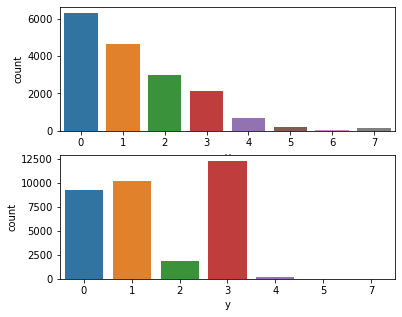

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(6., 5.))
fig.add_subplot(2, 1, 1)
sns.countplot(data=train, x='y')
fig.add_subplot(2, 1, 2)
sns.countplot(data=submission, x='y')
display(train.y.value_counts(normalize=True).sort_index())
display(submission.y.value_counts(normalize=True).sort_index())

In [16]:
submission.to_csv(os.path.join(OUTPUT_DIR, SUB_FILENAME), index=False)

In [17]:
metrics.loc['mean', 'train'], metrics.loc['mean', 'valid']

(0.9132594762976792, 0.22806577096778202)

In [18]:
print('"{}","{}","{:.6f}","{:.6f}","","{}"'.format(SUB_FILENAME, CV, metrics.loc['mean', 'train'], metrics.loc['mean', 'valid'], NOTE))

"012_submission.csv","Stratified-Kfold(K=5)","0.913259","0.228066","","全特徴量を使用したSVM. class_weight を指定。Cは100"


In [19]:
%%time
for i, model in enumerate(models):
    with open(os.path.join(OUTPUT_DIR, f'model_fold{i + 1}.pickle'), 'wb') as f:
        pickle.dump(model, f)
        f.close()

Wall time: 1.28 s
